# Assignment 3 - Stochastic Processes

    Name: Clara Periago
    Student #: s1067476

In [8]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.experimental import io_callback
from pathlib import Path
import opensimplex as opsx
import fastplotlib as fpl
import numpy as np
from pathlib import Path

In [2]:
# these are copy pasted from the last exercise
def rk4(f, dt):
    @jax.jit
    def step(x, t):
        k1 = f(t, x)
        k2 = f(t + .5 * dt, x + .5 * dt * k1)
        k3 = f(t + .5 * dt, x + .5 * dt * k2)
        k4 = f(t + dt, x + dt * k3)

        xn1 = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        return xn1

    return step

In [33]:
lapl = jnp.array(
    [[0.05, 0.2, 0.05],
     [0.2, -1.0, 0.2],
     [0.05, 0.2, 0.05]]
)
dx = 2.
lapl = lapl / (dx * dx)

def draw_fn(ax, grid):
    A, B = grid
    ax.imshow((B / (A + B)).T, cmap='Spectral')

def diffuse(k_i, dk):
    return dk * jax.scipy.signal.convolve2d(k_i, lapl, mode="same", boundary="fill", fillvalue=0)

def step_n(solver, n):
    def _step(x):
        def body(x, _):
            return solver(x, 0.0), None
        x, _ = jax.lax.scan(body, x, None, length=n)
        return x
    return _step

def capacity_from_height(H, strength=0.3, gamma=2.0):
    return 1.0 - strength * jnp.abs(H) ** gamma

def bunny_dynamics(dK, dt, feed, kill, reproduction, terrain):
    def f(t, c):
        K = c  # (k, w, h)
        G, B = K # Grass, Bunny
        # G, B = jnp.clip(K, 0, 1) # Grass, Bunny

        H = terrain # (w, h)
        K_G = capacity_from_height(H)

        bunnies_reproduced = reproduction * G * B**2

        next_K = jnp.array([
            feed * (K_G - G) - bunnies_reproduced,
            - (kill + feed) * B + bunnies_reproduced + .01 * reproduction * G * B,
        ])
        #next_K = jnp.zeros_like(K)

        k_diffused = jax.vmap(diffuse, in_axes=(0, 0))(K, dK)

        next_K = k_diffused + next_K
        
        return next_K
    
    def gup(x, t):
        return f(t, x)
 
    solver = jax.jit(rk4(f, dt))
    # solver = gup

    return solver

def draw_circle(grid, cx, cy, radius, strength, channel=1):
    """
    grid: (C, W, H)
    cx, cy: center coordinates
    radius: circle radius
    value: value to write inside the circle
    channel: which channel to write to
    """
    _, w, h = grid.shape

    xs = jnp.arange(w)[:, None]
    ys = jnp.arange(h)[None, :]

    # mask = (xs - cx)**2 + (ys - cy)**2 <= radius**2
    dist2 = (xs - cx)**2 + (ys - cy)**2
    brush = jnp.exp(-dist2 / (2 * radius**2))

    return grid.at[channel].add(strength * brush)


    # return grid.at[channel].set(
    #     jnp.where(mask, value, grid[channel])
    # )

def get_heightmap(w, h, seed, scale=24., regenerate=False):
    fname = f"heightmap_w{w}_h{h}_seed{seed}_scale{scale}.npy"
    out_dir = Path('./out')
    out_dir.mkdir(exist_ok=True)

    file = out_dir / fname
    if file.exists() and not regenerate:
        return jnp.asarray(np.load(file))
    
    opsx.seed(seed)
    heightmap = opsx.noise2array(
        jnp.arange(w) / scale,
        jnp.arange(h) / scale
    )
    np.save(file, np.asarray(.5 * (1. + heightmap)))
    return heightmap

In [34]:
dt = 1.
t = jnp.arange(0, 5000, dt)
dK = jnp.array([1.0, 0.5])
w, h = 320, 320
wh = jnp.array([w, h])

grid = jnp.stack(
    [
        jnp.ones(shape=(w, h)),#, dtype=jnp.uint8),
        jnp.zeros(shape=(w, h))#, dtype=jnp.uint8)
    ]
)

seed_size = 110
key = jr.key(42)
seed_locations = jr.uniform(key, shape=(seed_size, 2), minval=0., maxval=wh)
# grid = grid.at[
#     1,
#     int(w / 2) - int(seed_size / 2) : int(w / 2) + int(seed_size / 2) + 1,
#     int(h / 2) - int(seed_size / 2) : int(h / 2) + int(seed_size / 2) + 1,
# ].set(.4*jnp.ones((seed_size, seed_size)))#, dtype=jnp.uint8) * 255)
for x, y in seed_locations:
    grid = draw_circle(grid, x, y, 2, .6, channel=1)
# grid = draw_circle(grid, w//2-5, h//2-5, 5, .4, channel=1)
heightmap = get_heightmap(w, h, seed=42)

solver = bunny_dynamics(dK, dt, .0367, .0649, 1., terrain=heightmap)
s0 = grid  # initial state

In [35]:
heightmap.min()

Array(0.06706196, dtype=float32)

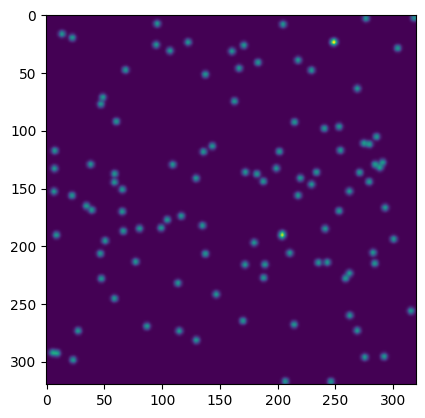

In [36]:
plt.imshow(s0[1])

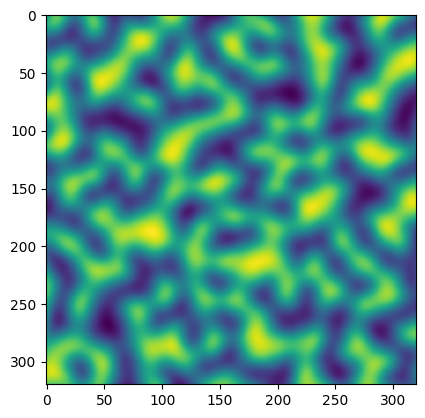

In [37]:
plt.imshow(heightmap)

In [101]:
import skimage.measure as measure

levels = jnp.linspace(heightmap.min(), heightmap.max(), 8)
contours = []
for level in levels:
    cc = measure.find_contours(np.asarray(heightmap), level)
    for c in cc:
        if c.shape[0] >= 2:   # must have at least 2 points
            contours.append(c[:, ::-1])

RFBOutputContext()

JupyterRenderCanvas(css_height='560.0px', css_width='700.0px')
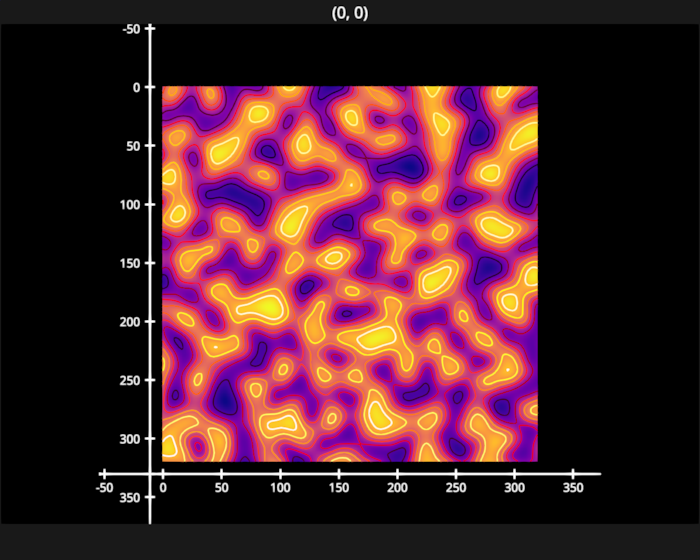

In [117]:
len(contours[1])
fig = fpl.Figure(size=(700, 560))
fig[0, 0].add_image(heightmap)
fig[0, 0].add_line_collection(
    data=contours,
    colors=(0, 0, 0, 0.25),  # translucent black
    cmap="hot",
    thickness=1.4,
)
fig.show()

RFBOutputContext()

JupyterRenderCanvas(css_height='560.0px', css_width='700.0px')
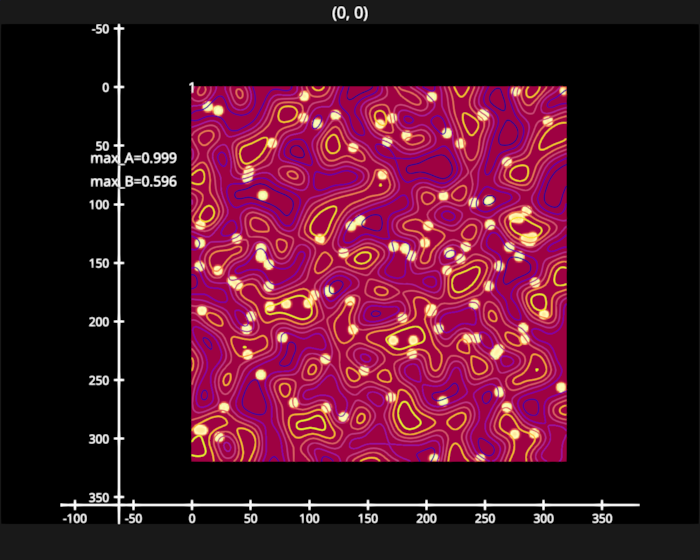

27 186
83 182
94 184
107 193
112 220
82 234
70 254
48 263
14 263
14 264
28 237
55 58
119 79


In [123]:
fig = fpl.Figure(size=(700, 560))
fig.canvas.max_buffered_frames = 1

fig[0, 0].add_line_collection(
    data=contours,
    colors=(0, 0, 0, 0.25),  # translucent black
    cmap="plasma",
    thickness=1.4,
)

data = jnp.zeros((320, 320))
image = fig[0, 0].add_image(
    data=data,
    name="random-image",
    cmap="Spectral",
    vmin=0.,
    vmax=1.,
    # offset=(0., 0., 2.),
)
fig[0, 0].add_text(text="0", name="frame")
fig[0, 0].add_text(text="0", name="max_A", offset=(-50,60, 0))
fig[0, 0].add_text(text="0", name="max_B", offset=(-50, 80, 0))
marker_index = 0
current_x = s0
STEPS_PER_FRAME = 20
stepper = jax.jit(step_n(solver, STEPS_PER_FRAME))

# for level_contours in contours:
#     for c in level_contours:
#         fig[0, 0].add_line(
#             data=c,
#             colors=(0, 0, 0, 0.25),  # translucent black
#             thickness=2,
#             uniform_color=True,
#             offset=(0,0,0),
#             #name="terrain-contour"
#         )

# a function to update the image
# a figure-level animation function will optionally take the figure as an argument
def update_data():
    global marker_index, current_x
    marker_index += 1

    if marker_index == t.shape[0]:
        marker_index = 0

    current_x = stepper(current_x)

    A, B = jnp.clip(current_x, 0, 1)
    frame = B
    
    fig[0, 0]["random-image"].data = frame
    fig[0, 0]["frame"].text = str(marker_index)
    fig[0, 0]["max_A"].text = f"max_A={jnp.max(A):.3f}"
    fig[0, 0]["max_B"].text = f"max_B={jnp.max(B):.3f}"


@fig.renderer.add_event_handler("key_down")
def toggle(ev):
    if ev.key == "t":
        for g in fig[0, 0].graphics:
            if isinstance(g, fpl.LineGraphic) or isinstance(g, fpl.LineCollection):
                g.visible = not g.visible

@image.add_event_handler("pointer_down")
def click_event(ev):
    global current_x
    # get the click location in screen coordinates
    xy = (ev.x, ev.y)

    # map the screen coordinates to world coordinates
    xy = fig[0, 0].map_screen_to_world(xy)[:-1]
    y, x = jnp.array(xy, dtype=int)

    # print the click location
    current_x = draw_circle(current_x, x, y, 2, .3, channel=1)
    print(x, y)

# you can also add animation functions to individual subplots
def update_data_subplot(subplot_instance):
    pass

# add this as an animation function
fig.add_animations(update_data)

# similarly you can add animation function to a subplot
# fig[0, 0].add_animations(update_data_subplot)

# show the plot
fig.show()

In [63]:
frames = xyz_history[:, 1] / (xyz_history[:, 0] + xyz_history[:, 1])

iw = fpl.ImageWidget(
    data=frames,
    cmap="Spectral",
    figure_kwargs={"size": (700, 560)},
    graphic_kwargs={"vmin": 0.0, "vmax": 1.1},
)
iw.show()

NameError: name 'xyz_history' is not defined